## <font color='darkblue'>Preface</font>
([article source](https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/)) <font size='3ptx'><b>"If 80 percent of our work is data preparation, then ensuring data quality is the important work of a machine learning team.” - – Andrew Ng</b> Feature engineering is one of the most important steps in machine learning. It is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Think machine learning algorithm as a learning child the more accurate information you provide the more they will be able to interpret the information well. Focusing first on our data will give us better results than focusing only on models. Feature engineering helps us to create better data which helps the model understand it well and provide reasonable results.</font>

<b>NLP is a subfield of artificial intelligence where we understand human interaction with machines using natural languages</b>. To understand a natural language, you need to understand how we write a sentence, how we express our thoughts using different words, signs, special characters, etc basically we should understand the context of the sentence to interpret its meaning.

<b>If we can use these contexts as features and feed them to our model then the model will be able to understand the sentence better</b>. Some of the common features that we can extract from a sentence are the number of words, number of capital words, number of punctuation, number of unique words, number of stopwords, average sentence length, etc. We can define these features based on our data set we are using. In this blog, we will use a Twitter data set so we can add some others features like the number of hashtags, number of mentions, etc. We will discuss them in detail in the coming sections.

<a id='sect0'></a>
### <font color='darkgreen'>Table of Content</font>
* <font size='3ptx'><b><a href='#sect1'>NLP task overview</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>List of features with code</a></b></font>
* <font size='3ptx'><b><a href='#sect3'>Implementation</a></b></font>
* <font size='3ptx'><b><a href='#sect4'>Results comparison with and without doing feature engineering</a></b></font>
* <font size='3ptx'><b><a href='#sect5'>Conclusion</a></b></font>

In [187]:
import pandas as pd
import seaborn as sns
import sys
import re
import math
import nltk
import numpy as np
import pandas as pd
import warnings
from collections import Counter, defaultdict
from datetime import datetime, timedelta
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer, sent_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [2]:
#nltk.download('stopwords')
#nltk.download('punkt')

In [2]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [62]:
RANDOM_STATE = 42
RF_N_ESTIMATORS = 500
RF_MIN_SAMPLES_SPLIT = 15

<a id='sect1'></a>
## <font color='darkblue'>NLP task overview</font>
<font size='3ptx'><b>To understand the feature engineering task in NLP, we will be implementing it on a Twitter dataset</b>. We will be using COVID-19 Fake News Dataset. The task is to classify the tweet as Fake or Real.</font>

You can download the dataset from [here](https://www.kaggle.com/datasets/arashnic/covid19-fake-news?resource=download) (or [here](https://github.com/MiHarsh/Public_stuffs)). The dataset is divided into train, validation, and test set.  Below is the distribution,

In [4]:
train_df = pd.read_csv('https://raw.githubusercontent.com/MiHarsh/Public_stuffs/master/Constraint_English_Train%20-%20Sheet1.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/MiHarsh/Public_stuffs/master/Constraint_English_Val%20-%20Sheet1.csv')

In [5]:
print(train_df.shape)
train_df.sample(n=3)

(6420, 3)


,id,tweet,label
4768,4769,Arizona's cases are declining and although tes...,real
6141,6142,BREAKING: Boris Johnson set to announce pubs b...,real
2984,2985,Non-#COVID19 patients continue to require cont...,real


In [6]:
test_df.sample(n=3)

,id,tweet,label
1735,1736,Commonly used drugs hydroxychloroquine and chl...,fake
1086,1087,First case of coronavirus traced to Marine put...,fake
316,317,???Covid-19 means ???certificate of identifica...,fake


Below is the distribution:

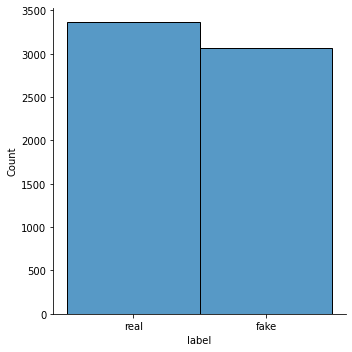

In [7]:
# training data
sns.displot(train_df, x="label")

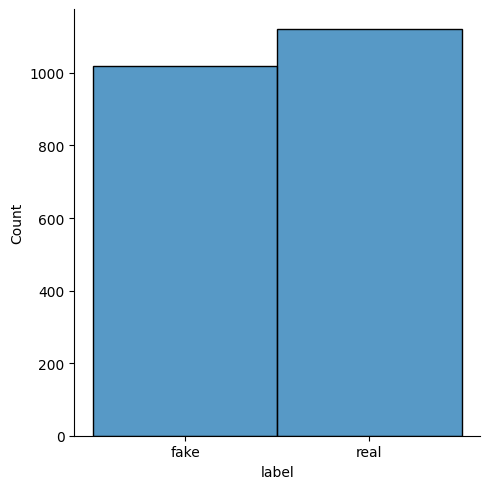

In [8]:
# testing data
sns.displot(test_df, x="label")

<a id='sect2'></a>
## <font color='darkblue'>List of features</font> ([back](#sect0))
I will be listing out a total of 15 features that we can use for the above dataset, number of features totally depends upon the type of dataset you are using.

#### 1. Number of Characters
Count the number of characters present in a tweet.

In [9]:
def count_chars(text):
    return len(text)

#### 2. Number of words
Count the number of words present in a tweet.

In [10]:
def count_words(text):
    return len(text.split())

#### 3. Number of capital characters
Count the number of capital characters present in a tweet.

In [11]:
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

#### 4. Number of capital words
Count the number of capital words present in a tweet.

In [12]:
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

#### 5. Count the number of punctuations
In this function, we return a dictionary of 32 punctuation with the counts, which can be used as separate features, which I will discuss in the next section.

In [13]:
def count_punctuations(text):
    punctuations='!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 

#### 6. Number of words in quotes
The number of words in the single quotation and double quotation.

In [14]:
def count_words_in_quotes(text):
    x = re.findall("'.'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

#### 7. Number of sentences
Count the number of sentences in a tweet.

In [15]:
def count_sent(text):
    return len(nltk.sent_tokenize(text))

#### 8. Count the number of unique words
Count the number of unique words in a tweet.

In [16]:
def count_unique_words(text):
    return len(set(text.split()))

#### 9. Count of hashtags
Since we are using the Twitter dataset we can count the number of times users used the hashtag.

In [17]:
def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x) 

#### 10. Count of mentions
On Twitter, most of the time people reply or mention someone in their tweet, counting the number of mentions can also be treated as a feature.

In [18]:
def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

#### 11. Count of stopwords
Here we will count the number of stopwords used in a tweet.

In [19]:
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

#### 12. Calculating average word length
This can be calculated by dividing the counts of characters by counts of words.
```python
train_df['avg_wordlength'] = train_df['char_count']/train_df['word_count']
```

#### 13. Calculating average sentence length
This can be calculated by dividing the counts of words by the counts of sentences.
```python
train_df['avg_sentlength'] = train_df['word_count']/train_df['sent_count']
```

#### 14. unique words vs word count feature
This feature is basically the ratio of unique words to a total number of words.
```python
df['unique_vs_words'] = df['unique_word_count']/df['word_count']
```

#### 15. Stopwords count vs words counts feature
This feature is also the ratio of counts of stopwords to the total number of words.
```python
df['stopwords_vs_words'] = df['stopword_count']/df['word_count']
```

<a id='sect3'></a>
## <font color='darkblue'>Implementation</font> ([back](#sect0))
We will focus more on feature engineering, for this we will keep the approach simple, by using TF-IDF and simple pre-processing. All the code will be available on my GitHub repository https://github.com/ahmadkhan242/Feature-Engineering-in-NLP.

### <font color='darkgreen'>Applying the above-defined feature extraction on train and test set</font>

In [20]:
def gen_features(df):
    df['char_count'] = df["tweet"].apply(lambda x:count_chars(x))
    df['word_count'] = df["tweet"].apply(lambda x:count_words(x))
    df['sent_count'] = df["tweet"].apply(lambda x:count_sent(x))
    df['capital_char_count'] = df["tweet"].apply(lambda x:count_capital_chars(x))
    df['capital_word_count'] = df["tweet"].apply(lambda x:count_capital_words(x))
    df['quoted_word_count'] = df["tweet"].apply(lambda x:count_words_in_quotes(x))
    df['stopword_count'] = df["tweet"].apply(lambda x:count_stopwords(x))
    df['unique_word_count'] = df["tweet"].apply(lambda x:count_unique_words(x))
    df['htag_count'] = df["tweet"].apply(lambda x:count_htags(x))
    df['mention_count'] = df["tweet"].apply(lambda x:count_mentions(x))
    df['punct_count'] = df["tweet"].apply(lambda x:count_punctuations(x))
    df['avg_wordlength'] = df['char_count']/df['word_count']
    df['avg_sentlength'] = df['word_count']/df['sent_count']
    df['unique_vs_words'] = df['unique_word_count']/df['word_count']
    df['stopwords_vs_words'] = df['stopword_count']/df['word_count']
    return df

In [21]:
train_df = gen_features(train_df)
test_df = gen_features(test_df)

In [23]:
print(train_df.shape)
train_df.sample(n=3)

(6420, 18)


,id,tweet,label,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
3578,3579,"Jacob Rees-Mogg has told people to stop the ""e...",real,183,25,1,5,0,0,9,24,0,0,"{'! count': 0, '"" count': 4, '# count': 1, '$ ...",7.320000,25.000000,0.960000,0.360000
6278,6279,Over the last 5 days we have processed more th...,real,262,47,3,2,0,0,17,42,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",5.574468,15.666667,0.893617,0.361702
3901,3902,Two West Virginia Brothers Can't Afford Covid-...,fake,138,19,1,21,0,0,1,18,0,0,"{'! count': 0, '"" count': 0, '# count': 1, '$ ...",7.263158,19.000000,0.947368,0.052632


### <font color='darkgreen'>Adding some extra features using punctuation count</font>
We will create a DataFrame from the dictionary returned by the “punct_count” function and then merge it with the main dataset.

In [24]:
test_punct_df = pd.DataFrame(list(test_df.punct_count))
train_punct_df = pd.DataFrame(list(train_df.punct_count))
train_punct_df.head(n=3)

,! count,""" count",# count,$ count,% count,& count,' count,( count,) count,* count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Merging pnctuation DataFrame with main DataFrame
train_df = pd.merge(train_df, train_punct_df, left_index=True, right_index=True)
test_df = pd.merge(test_df, test_punct_df, left_index=True, right_index=True)
train_df.sample(n=3)

,id,tweet,label,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
6109,6110,567 positive cases and 39 deaths from COVID-19...,fake,86,16,1,7,1,0,5,...,0,0,0,0,0,0,0,0,0,0
2530,2531,The latest CDC #COVIDView report shows that th...,real,277,34,2,27,2,0,11,...,0,0,0,0,0,0,0,0,0,0
1114,1115,Text in Lithuanian excerpted from a letter cla...,fake,102,17,1,5,1,0,7,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# We can drop "punct_count" column from both df and test DataFrame
train_df.drop(columns=['punct_count'], inplace=True)
test_df.drop(columns=['punct_count'], inplace=True)
train_df.columns

Index(['id', 'tweet', 'label', 'char_count', 'word_count', 'sent_count',
       'capital_char_count', 'capital_word_count', 'quoted_word_count',
       'stopword_count', 'unique_word_count', 'htag_count', 'mention_count',
       'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', '! count', '" count', '# count', '$ count',
       '% count', '& count', '' count', '( count', ') count', '* count',
       '+ count', ', count', '- count', '. count', '/ count', ': count',
       '; count', '< count', '= count', '> count', '? count', '@ count',
       '[ count', '\ count', '] count', '^ count', '_ count', '` count',
       '{ count', '| count', '} count', '~ count'],
      dtype='object')

### <font color='darkgreen'>Re-processing</font>
We performed a simple pre-processing step, like removing links, removing user name, numbers, double space, punctuation, lower casing, etc.

In [27]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'httpS+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RTs@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

my_punctuation = '!"$%&\'()*+,-./:;<=>?[\]^_`{|}~•@'
    
def preprocess(sent):
    sent = remove_users(sent)
    sent = remove_links(sent)
    sent = sent.lower() # lower case
    sent = re.sub('['+my_punctuation + ']+', ' ', sent) # strip punctuation
    sent = re.sub('s+', ' ', sent) #remove double spacing
    sent = re.sub('([0-9]+)', '', sent) # remove numbers
    sent_token_list = [word for word in sent.split(' ')]
    sent = ' '.join(sent_token_list)
    return sent

train_df['tweet']   = train_df['tweet'].apply(lambda x: preprocess(x))
test_df['tweet'] = test_df['tweet'].apply(lambda x: preprocess(x))

In [28]:
train_df.columns

Index(['id', 'tweet', 'label', 'char_count', 'word_count', 'sent_count',
       'capital_char_count', 'capital_word_count', 'quoted_word_count',
       'stopword_count', 'unique_word_count', 'htag_count', 'mention_count',
       'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', '! count', '" count', '# count', '$ count',
       '% count', '& count', '' count', '( count', ') count', '* count',
       '+ count', ', count', '- count', '. count', '/ count', ': count',
       '; count', '< count', '= count', '> count', '? count', '@ count',
       '[ count', '\ count', '] count', '^ count', '_ count', '` count',
       '{ count', '| count', '} count', '~ count'],
      dtype='object')

### <font color='darkgreen'>Encoding text</font>
We will encode our text data using [**TF-IDF**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). We first fit transform on our train and test set’s tweet column and then merge it with all features columns.

In [188]:
# TF-IDF example
sample_doc_df = pd.DataFrame([
    ['this is a a sample'],
    ['this is another another example example example'],
], columns=['text'])
sample_doc_df

,text
0,this is a a sample
1,this is another another example example example


In [189]:
# https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
vectorizer =  TfidfVectorizer()
vectorizer.fit(sample_doc_df['text'])
tfidf_df = pd.DataFrame(
    vectorizer.transform(sample_doc_df['text']).toarray(),
    columns=vectorizer.get_feature_names_out())
tfidf_df

,another,example,is,sample,this
0,0.000000,0.000000,0.501549,0.704909,0.501549
1,0.534284,0.801426,0.190074,0.000000,0.190074


In [190]:
%%time
vectorizer            =  TfidfVectorizer()
train_tf_idf_features =  vectorizer.fit_transform(train_df['tweet']).toarray()
test_tf_idf_features  =  vectorizer.transform(test_df['tweet']).toarray()

# Converting above list to DataFrame
train_tf_idf_df          = pd.DataFrame(train_tf_idf_features)
test_tf_idf_df           = pd.DataFrame(test_tf_idf_features)

# Saparating train and test labels from all features
y_train               = train_df['label']
y_test                = test_df['label']

#Listing all features
features = ['char_count', 'word_count', 'sent_count',
       'capital_char_count', 'capital_word_count', 'quoted_word_count',
       'stopword_count', 'unique_word_count', 'htag_count', 'mention_count',
       'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', '! count', '" count', '# count', '$ count',
       '% count', '& count', '\' count', '( count', ') count', '* count',
       '+ count', ', count', '- count', '. count', '/ count', ': count',
       '; count', '< count', '= count', '> count', '? count', '@ count',
       '[ count', '\ count', '] count', '^ count', '_ count', '` count',
       '{ count', '| count', '} count', '~ count']

# Finally merging all features with above TF-IDF. 
X_train = pd.merge(train_tf_idf_df, train_df[features], left_index=True, right_index=True)
X_test  = pd.merge(test_tf_idf_df, test_df[features], left_index=True, right_index=True)

CPU times: user 3.14 s, sys: 1.18 s, total: 4.31 s
Wall time: 4.34 s


In [191]:
X_train.sample(n=3)

,0,1,2,3,4,5,6,7,8,9,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
1941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### <font color='darkgreen'>Training</font>
For training, we will be using the Random forest algorithm ([**RandomForestClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) from the sci-kit learn library.

In [50]:
%%time
clf_model = RandomForestClassifier(
    n_estimators = 1000, min_samples_split = 15, random_state = RANDOM_STATE)
clf_model.fit(X_train, y_train)

CPU times: user 2min 4s, sys: 653 ms, total: 2min 5s
Wall time: 2min 5s


RandomForestClassifier(min_samples_split=15, n_estimators=1000, random_state=42)

In [51]:
y_pred = clf_model.predict(X_test)

In [52]:
y_pred[:10]

array(['fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real',
       'fake', 'fake'], dtype=object)

In [53]:
print(f'Accuracy: {accuracy_score(y_test, y_pred):.01%}')
print()
print(classification_report(y_test, y_pred))

Accuracy: 93.6%

              precision    recall  f1-score   support

        fake       0.97      0.89      0.93      1020
        real       0.91      0.97      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.93      0.94      2140
weighted avg       0.94      0.94      0.94      2140



<a id='sect4'></a>
## <font color='darkblue'>Result comparison</font> ([back](#sect0))
* <font size='3ptx'><b><a href='#sect4_1'>Without using Feature Engineering techniques</a></b></font>
* <font size='3ptx'><b><a href='#sect4_2'>Using Feature Engineering techniques</a></b></font>
* <font size='3ptx'><b><a href='#sect4_3'>Replace tf-idf with word-vector</a></b></font>
* <font size='3ptx'><b><a href='#sect4_4'>SVC + word2vec + feature engineering</a></b></font>
* <font size='3ptx'><b><a href='#sect4_5'>SVC (Grid search) + word2vec + feature engineering</a></b></font>
* <font size='3ptx'><b><a href='#sect4_6'>SVC + tf-idf + feature engineering</a></b></font>
* <font size='3ptx'><b><a href='#sect4_7'>SVC (Grid search) + tf-idf + feature engineering</a></b></font>
* <font size='3ptx'><b><a href='#sect4_8'>SVC + tf-idf + feature engineering + 2gram</a></b></font>
* <font size='3ptx'><b><a href='#sect4_9'>SVC + word2vec + PCA(tf-idf & feature engineering,100)</a></b></font>
* <font size='3ptx'><b><a href='#sect4_10'>SVC + word2vec + PCA(tf-idf & feature engineering,100) + 2gram</a></b></font>
<br/>

<font size='3ptx'><b>For comparison, we first trained our model on the above dataset by using features engineering techniques and then without using feature engineering techniques</b></font>.

In both approaches, we pre-processed the dataset using the same method as described above and TF-IDF was used in both approaches for encoding the text data. You can use whatever encoding techniques you want to use like word2vec, glove, etc.

In [192]:
perf_data = []

In [193]:
def insert_perf_data(y_pred, name, feature_size, train_time):
    y_test_binary = [1 if label=='fake' else 0 for label in y_test]
    y_pred_binary = [1 if label=='fake' else 0 for label in y_pred]
    accuracy = accuracy_score(y_test, y_pred)
    perf_data.append((
        name,
        feature_size,
        accuracy,
        recall_score(y_test_binary, y_pred_binary),
        precision_score(y_test_binary, y_pred_binary),
        f1_score(y_test_binary, y_pred_binary),
        train_time))

    print(f'Accuracy: {accuracy:.01%}')
    print(classification_report(y_test, y_pred))
    return perf_data[-1]

<a id='sect4_1'></a>
### <font color='darkgreen'>Without using Feature Engineering techniques</font> ([back](#sect4))
Here we only use features tf-idf:

In [196]:
%%time
st = datetime.now()
clf_model = RandomForestClassifier(
    n_estimators = RF_N_ESTIMATORS, min_samples_split = RF_MIN_SAMPLES_SPLIT, random_state = RANDOM_STATE)
clf_model.fit(train_tf_idf_features, y_train)
train_time = datetime.now() - st

CPU times: user 3min 3s, sys: 0 ns, total: 3min 3s
Wall time: 3min 3s


In [197]:
y_pred = clf_model.predict(test_tf_idf_features)

In [198]:
insert_perf_data(
    y_pred, 'randomforest + tf-idf', train_tf_idf_features.shape[1],
    train_time)

Accuracy: 91.3%
              precision    recall  f1-score   support

        fake       0.94      0.87      0.91      1020
        real       0.89      0.95      0.92      1120

    accuracy                           0.91      2140
   macro avg       0.92      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



('randomforest + tf-idf',
 13872,
 0.9130841121495327,
 0.8745098039215686,
 0.9389473684210526,
 0.9055837563451777,
 datetime.timedelta(seconds=183, microseconds=325149))

In [ ]:
'''
perf_data.append(
    ('randomforest + tf-idf',
     13872,
     0.9121495327102803,
     0.8745098039215686,
     0.9369747899159664,
     0.9046653144016227,
     datetime.timedelta(seconds=152)))
'''
#

<a id='sect4_2'></a>
### <font color='darkgreen'>Using Feature Engineering techniques</font> ([back](#sect4))
Here we used up all features we have:

In [199]:
%%time
st = datetime.now()
clf_model = RandomForestClassifier(
    n_estimators = RF_N_ESTIMATORS, min_samples_split = RF_MIN_SAMPLES_SPLIT, random_state = RANDOM_STATE)
clf_model.fit(X_train, y_train)
train_time = datetime.now() - st

CPU times: user 1min 2s, sys: 0 ns, total: 1min 2s
Wall time: 1min 2s


In [200]:
y_pred = clf_model.predict(X_test)

In [201]:
insert_perf_data(
    y_pred, 'randomforest + tf-idf + feature engineering',
    X_train.shape[1], train_time)

Accuracy: 93.2%
              precision    recall  f1-score   support

        fake       0.96      0.89      0.93      1020
        real       0.91      0.97      0.94      1120

    accuracy                           0.93      2140
   macro avg       0.94      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



('randomforest + tf-idf + feature engineering',
 13918,
 0.9317757009345794,
 0.8892156862745098,
 0.9648936170212766,
 0.9255102040816325,
 datetime.timedelta(seconds=62, microseconds=310574))

In [70]:
'''
perf_data.append(
    ('randomforest + tf-idf + feature engineering',
     13918,
     0.9336448598130841,
     0.8911764705882353,
     0.9670212765957447,
     0.9275510204081633,
     timedelta(minutes=1, seconds=3)))
'''

"\nperf_data.append(\n    ('randomforest + tf-idf + feature engineering',\n     13918,\n     0.9336448598130841,\n     0.8911764705882353,\n     0.9670212765957447,\n     0.9275510204081633,\n     timedelta(minutes=1, seconds=3)))\n"

<a id='sect4_3'></a>
### <font color='darkgreen'>Replace tf-idf with word-vector</font> ([back](#sect4))

Here we use [**word2vec**](https://en.wikipedia.org/wiki/Word2vec) to replace tf-idf:

In [202]:
#!pip3 install gensim
test_tf_idf_features = train_tf_idf_features = None

In [203]:
import gensim.downloader as api
from gensim.models import Word2Vec

In [204]:
w2v_feature_names = [f'w{i}' for i in range(300)]

def text2w2v(df, column='tweet', only_w2v=False):
    """Turns text into word2vect"""
    model = api.load("word2vec-google-news-300") 
    wv_list = []
    for ri, row in df.iterrows():
        vector = np.zeros(300)
        for w in row.get(column).split():
            try:
                vector += model[w]
            except Exception as e:
                pass
            
        wv_list.append(vector)
        
    w2v_df = pd.DataFrame(wv_list, columns=w2v_feature_names)
    if only_w2v:
        return w2v_df
    
    df = pd.concat([df, w2v_df], axis=1)
    return df

In [205]:
%%time
train_df = text2w2v(train_df)

CPU times: user 51.9 s, sys: 5.93 s, total: 57.8 s
Wall time: 58.2 s


In [206]:
%%time
test_df = text2w2v(test_df)

CPU times: user 49.7 s, sys: 2.85 s, total: 52.6 s
Wall time: 52.7 s


In [207]:
print(train_df.shape)
train_df.sample(n=3)

(6420, 949)


,id,tweet,label,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,w290,w291,w292,w293,w294,w295,w296,w297,w298,w299
5645,5646,our total number of confirmed ca e of covid ...,real,238,40,1,10,1,0,15,...,-0.942078,1.282257,-2.360809,-0.252247,0.365173,-0.709702,-0.553467,-1.146214,-0.391052,-0.863144
4360,4361,bloke who e mi o ha to top him from a puttin...,fake,150,22,1,33,3,0,0,...,0.039013,1.947937,-1.239754,1.653015,-0.979614,-1.617981,-0.126404,-0.890869,-1.087830,1.596802
6185,6186,the end of the world i nigh http t co xilglu...,fake,102,13,1,11,0,0,0,...,-0.005615,0.537781,-0.464722,1.222900,-0.014404,-0.854614,-0.741211,-0.064758,-0.262695,0.596497


In [208]:
X_train = train_df[features + w2v_feature_names]
X_test  = test_df[features + w2v_feature_names]

In [209]:
%%time
st = datetime.now()
clf_model = RandomForestClassifier(
    n_estimators = RF_N_ESTIMATORS, min_samples_split = RF_MIN_SAMPLES_SPLIT,
    random_state = RANDOM_STATE)
clf_model.fit(X_train, y_train)
train_time = datetime.now() - st

CPU times: user 1min 33s, sys: 0 ns, total: 1min 33s
Wall time: 1min 33s


In [210]:
y_pred = clf_model.predict(X_test)

In [211]:
insert_perf_data(
    y_pred, 'randomforest + word2vec + feature engineering',
    X_train.shape[1], train_time)

Accuracy: 89.0%
              precision    recall  f1-score   support

        fake       0.90      0.86      0.88      1020
        real       0.88      0.92      0.90      1120

    accuracy                           0.89      2140
   macro avg       0.89      0.89      0.89      2140
weighted avg       0.89      0.89      0.89      2140



('randomforest + word2vec + feature engineering',
 946,
 0.8901869158878505,
 0.8607843137254902,
 0.9042224510813595,
 0.8819688598694123,
 datetime.timedelta(seconds=93, microseconds=162035))

In [55]:
'''
perf_data.append(
    ('randomforest + word2vec + feature engineering',
     346,
     0.908411214953271,
     0.8725490196078431,
     0.9309623430962343,
     0.9008097165991903)
)
'''

<a id='sect4_4'></a>
### <font color='darkgreen'>SVC + word2vec + feature engineering</font> ([back](#sect4))

In [212]:
%%time
st = datetime.now()
clf_model = make_pipeline(StandardScaler(), SVC())
clf_model.fit(X_train, y_train)
train_time = datetime.now() - st

CPU times: user 13.5 s, sys: 0 ns, total: 13.5 s
Wall time: 13.5 s


In [213]:
y_pred = clf_model.predict(X_test)

In [214]:
insert_perf_data(
    y_pred, 'SVC + word2vec + feature engineering',
    X_train.shape[1], train_time)

Accuracy: 92.5%
              precision    recall  f1-score   support

        fake       0.92      0.92      0.92      1020
        real       0.93      0.93      0.93      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



('SVC + word2vec + feature engineering',
 946,
 0.9247663551401869,
 0.9205882352941176,
 0.9214916584887144,
 0.9210397253555664,
 datetime.timedelta(seconds=13, microseconds=514017))

In [56]:
'''
perf_data.append(
    ('SVC + word2vec + feature engineering',
     346,
     0.9294392523364486,
     0.9215686274509803,
     0.9297725024727992,
     0.9256523879862137)
)
'''

<a id='sect4_5'></a>
### <font color='darkgreen'>SVC(Grid search) + word2vec + feature engineering</font> ([back](#sect4))
Please refer to ["Searching for optimal parameters with successive halving"](https://scikit-learn.org/stable/modules/grid_search.html#searching-for-optimal-parameters-with-successive-halving)

In [215]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)

StandardScaler()

In [216]:
%%time
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01 ],'kernel': ['rbf', 'poly']}

st = datetime.now()
grid = GridSearchCV(
    SVC(), param_grid, refit=True, verbose=2, n_jobs=-1)
X_train_scaled = std_scaler.transform(X_train)
grid.fit(X_train_scaled, y_train)                      
train_time = datetime.now() - st

Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: user 13.9 s, sys: 1.02 s, total: 15 s
Wall time: 4min 37s


In [217]:
X_test_scaled = std_scaler.transform(X_test)
y_pred = grid.predict(X_test_scaled)

In [218]:
insert_perf_data(
    y_pred, 'Grid search SVC + word2vec + feature engineering',
    X_train.shape[1], train_time)

Accuracy: 92.0%
              precision    recall  f1-score   support

        fake       0.92      0.91      0.92      1020
        real       0.92      0.93      0.92      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



('Grid search SVC + word2vec + feature engineering',
 946,
 0.9200934579439253,
 0.907843137254902,
 0.9232303090727817,
 0.9154720711814137,
 datetime.timedelta(seconds=277, microseconds=684995))

In [57]:
'''
perf_data.append(
    ('Grid search SVC + word2vec + feature engineering',
     346,
     0.9205607476635514,
     0.9362745098039216,
     0.9009433962264151,
     0.9182692307692307)
)
'''

<a id='sect4_6'></a>
### <font color='darkgreen'>SVC + tf-idf + feature engineering</font> ([back](#sect4))

In [219]:
# TF-IDF + Feature engineering
X_train = pd.merge(pd.DataFrame(vectorizer.transform(train_df['tweet']).toarray()),
                   train_df[features], left_index=True, right_index=True)
X_test  = pd.merge(pd.DataFrame(vectorizer.transform(test_df['tweet']).toarray()),
                   test_df[features], left_index=True, right_index=True)

In [220]:
print(X_train.shape)
X_train.sample(n=3)

(6420, 13918)


,0,1,2,3,4,5,6,7,8,9,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [221]:
X_train.columns = X_test.columns = [f'f-{i}' for i in range(X_train.shape[1])]

In [222]:
%%time
st = datetime.now()
clf_model = make_pipeline(StandardScaler(), SVC())
clf_model.fit(X_train, y_train)
train_time = datetime.now() - st

[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.1min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=  25.7s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time= 1.1min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.1min
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=  32.6s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.2min
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time= 1.0min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.1min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=  27.2s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time= 1.2min
[CV] END ...................

In [223]:
%%time
y_pred = clf_model.predict(X_test)

CPU times: user 54min 30s, sys: 1h 35min 55s, total: 2h 30min 26s
Wall time: 9min 37s


In [224]:
insert_perf_data(
    y_pred, 'SVC + tf-idf + feature engineering',
    X_train.shape[1], train_time)

Accuracy: 92.6%
              precision    recall  f1-score   support

        fake       0.93      0.91      0.92      1020
        real       0.92      0.94      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



('SVC + tf-idf + feature engineering',
 13918,
 0.9257009345794392,
 0.9137254901960784,
 0.9292123629112662,
 0.921403855659911,
 datetime.timedelta(seconds=434, microseconds=36797))

In [58]:
'''
perf_data.append(
    ('SVC + tf-idf + feature engineering',
     13918,
     0.9257009345794392,
     0.9137254901960784,
     0.9292123629112662,
     0.921403855659911)
)
'''

<a id='sect4_7'></a>
### <font color='darkgreen'>SVC(Grid search) + tf-idf + feature engineering</font> ([back](#sect4))

In [65]:
%%time
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],'kernel': ['rbf', 'poly']}
st = datetime.now()
grid = GridSearchCV(
    SVC(), param_grid, refit=True, verbose=2, n_jobs=-1)

grid.fit(X_train, y_train) 
train_time = datetime.now() - st

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=14.6min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 8.3min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=10.4min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=11.0min
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time= 7.0min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 8.9min
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time= 6.3min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=13.0min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=10.8min
[CV] END ..........................C=1, gamma=1, kernel=poly; total time= 7.6min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=11.6min
[CV] END ........................C=1, gamma=0.1,

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'poly']},
             verbose=2)

In [66]:
y_pred = grid.predict(X_test)

In [67]:
insert_perf_data(y_pred, 'Gridsearch SVC + tf-idf + feature engineering',
                 X_train.shape[1], train_time)

Accuracy: 94.3%
              precision    recall  f1-score   support

        fake       0.93      0.95      0.94      1020
        real       0.96      0.93      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140



('Gridsearch SVC + tf-idf + feature engineering',
 13918,
 0.9425233644859813,
 0.9519607843137254,
 0.9291866028708134,
 0.9404358353510895)

In [59]:
'''
perf_data.append(
    ('Gridsearch SVC + tf-idf + feature engineering',
     13918,
     0.9425233644859813,
     0.9519607843137254,
     0.9291866028708134,
     0.9404358353510895,
     timedelta())
)
'''

<a id='sect4_8'></a>
### <font color='darkgreen'>SVC + tf-idf + feature engineering + 2gram</font> ([back](#sect4))
Here we add 100 more features of 2 grams:

In [225]:
class TwoGramFeatures:
    """Class to collect 2gram features.
    
    Attributes:
        top_n: Number of 2gram to collect.
        min_doc_count: The limitation of minimum doc which 2gram should exist
            in order to be collected.
        text_column_name: The column name of dataframe as text to search for 2gram.
        label_column_name: The column name of dataframe as labeling result.
        fit_history: dict object with key as collected 2gram and value as its meta data
            such as score and doc count.
        fit_gram_list: The collrected 2gram list after fit.
    """
    HEAD_TOKEN_PLACEHOLDER = '__HEAD_TOKEN__'

    def __init__(self, text_column_name, label_column_name, top_n=100, min_doc_count=10):
        self.top_n = top_n
        self.min_doc_count = min_doc_count
        self.text_column_name = text_column_name
        self.label_column_name = label_column_name
        self.fit_history = {}
        self.fit_gram_list = ()
        self._tokenizer_words = TweetTokenizer()
        
        
    def __str__(self):
        return f'TwoGramFeatures(min_doc_count={self.min_doc_count}, top_n={self.top_n}): {len(self.fit_history)} 2gram(s)'
        
    def __len__(self):
        return len(self.fit_gram_list)
        
    def _reverse_entropy(self, prob_list):
        """Calculate the entropy of given probability list and take the reciprocal of it.
        
        For how to calculate entropy, please refer to:
        https://en.wikipedia.org/wiki/Entropy_(information_theory)
        
        Below are few examples for reference:
        ```
        (0, 1) with reverse-entropy as 9223372036854775807
        (1, 0) with reverse-entropy as 9223372036854775807
        (0.99, 0.01) with reverse-entropy as 17.85665359923201
        (0.1, 0.9) with reverse-entropy as 3.0761377305228823
        (0.3, 0.7) with reverse-entropy as 1.6370247805217761
        (0.5, 0.5) with reverse-entropy as 1.4426950408889634
        (0.3, 0.3, 0.3, 0.1) with reverse-entropy as 0.7611311434594984
        ```
        
        Args:
            prob_list: Probability list with sum up to 1.
            
        Returns:
            The reciprocal of entropy.
        """
        entropy_val = 0
        for prob in prob_list:
            if prob == 0:
                continue
            if prob == 1:
                break

            entropy_val += -1 * math.log(prob) * prob

        return 1/entropy_val if entropy_val else sys.maxsize
        
    def _gen_2grams(self, text_content):
        """Generates the 2gram counter."""
        token_counter = Counter()        
        for token_list in [self._tokenizer_words.tokenize(t) for t in nltk.sent_tokenize(text_content)]:
            first_token = token_list[0]
            for token in token_list[1:]:
                token_counter.update({(first_token, token): 1})
                token = first_token
            
        return token_counter
        
    def fit(self, df):
        """Fits the dataframe to collect 2gram information."""
        self.fit_history = {}
        self.fit_gram_list = ()
        doc_count = df.shape[0]
        token_doc_counter = Counter()
        token_label_dict = {}
        for ri, row in df.iterrows():
            label = row.get(self.label_column_name)
            text_content = row.get(self.text_column_name)
            gram_counter = self._gen_2grams(text_content)
            for gram in gram_counter.keys():
                token_doc_counter.update({gram: 1})
                if gram in token_label_dict:
                    token_label_dict[gram][label] += 1
                else:
                    token_label_dict[gram] = defaultdict(int)
                    token_label_dict[gram][label] += 1
        
        # Start calculating score and sorting the result
        toke_score_dict = {}
        for gram, doc_count in token_doc_counter.items():
            gram_label_count_list = token_label_dict[gram].values()
            selected_label = max(token_label_dict[gram].items(), key=lambda t: t[1])[0]
            gram_label_count_sum = sum(gram_label_count_list)
            prob_list = [count/gram_label_count_sum for count in gram_label_count_list]
            score = self._reverse_entropy(prob_list)
            toke_score_dict[gram] = (score, token_doc_counter[gram], selected_label)
            
        self.fit_history = sorted(filter(
            lambda t: t[1][1] >= self.min_doc_count,
            toke_score_dict.items()), key=lambda t: t[1], reverse=True)[:self.top_n]
        self.fit_gram_list = list(map(lambda t: t[0], self.fit_history))
        
    def transform(self, df):
        """Transforms the input dataframe into 2gram feature array."""
        datas = []
        for ri, row in df.iterrows():
            data = []
            gram_counter = self._gen_2grams(row.get(self.text_column_name))
            for gram in self.fit_gram_list:
                data.append(gram_counter.get(gram, 0))
                
            datas.append(data)
            
        return np.array(datas)
    
    def fit_transform(self, df):
        """Fits and transforms the input dataframe into 2gram feature array."""
        if not self.fit_history:
            self.fit(df)
            
        return self.transform(df)

In [226]:
%%time
two_gram_feats       =  TwoGramFeatures(text_column_name='tweet', label_column_name='label', top_n=150, min_doc_count=70)
train_2gram_features =  two_gram_feats.fit_transform(train_df)
test_2gram_features  =  two_gram_feats.transform(test_df)

# Converting above list to DataFrame
train_2gram_df          = pd.DataFrame(train_2gram_features,
                                       columns=[f'2gram_{i}' for i in range(train_2gram_features.shape[1])])
test_2gram_df           = pd.DataFrame(test_2gram_features,
                                       columns=[f'2gram_{i}' for i in range(test_2gram_features.shape[1])])

CPU times: user 8.59 s, sys: 279 ms, total: 8.87 s
Wall time: 8.89 s


In [227]:
print(two_gram_feats)
list(two_gram_feats.fit_history[-20:])

TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)


[(('the', 'in'), (1.5409374900486654, 244, 'real')),
 (('the', 'and'), (1.5321818892033032, 184, 'real')),
 (('“', '”'), (1.5211716964420314, 79, 'real')),
 (('new', 'http'), (1.5115712940524648, 216, 'real')),
 (('new', 'co'), (1.5115712940524648, 216, 'real')),
 (('new', 'in'), (1.5115712940524648, 80, 'real')),
 (('the', 'the'), (1.5069846308721047, 343, 'real')),
 (('new', 'a'), (1.5053970611059928, 92, 'real')),
 (('new', 't'), (1.4979812997754336, 222, 'real')),
 (('the', 'that'), (1.4840344036129642, 97, 'real')),
 (('the', 'ha'), (1.4829071420985505, 119, 'real')),
 (('the', 'a'), (1.4812687067121846, 227, 'real')),
 (('the', 'i'), (1.4704089646857075, 217, 'real')),
 (('a', 'india'), (1.463225517964234, 79, 'real')),
 (('a', 'of'), (1.4576721754261794, 302, 'fake')),
 (('a', 't'), (1.45434081537911, 266, 'real')),
 (('a', 'for'), (1.4470427872201101, 124, 'fake')),
 (('the', 'it'), (1.4461030778165422, 70, 'fake')),
 (('the', 'covid'), (1.4440431617274436, 139, 'real')),
 (('a

In [228]:
train_2gram_df.sample(n=3)

,2gram_0,2gram_1,2gram_2,2gram_3,2gram_4,2gram_5,2gram_6,2gram_7,2gram_8,2gram_9,...,2gram_136,2gram_137,2gram_138,2gram_139,2gram_140,2gram_141,2gram_142,2gram_143,2gram_144,2gram_145
1851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [229]:
# Finally merging all features with above TF-IDF. 
X_train = pd.concat([train_df[features], train_2gram_df, train_tf_idf_df], axis=1)
X_test  = pd.concat([test_df[features], test_2gram_df, test_tf_idf_df], axis=1)

In [230]:
print(X_train.shape)
X_train.sample(n=3)

(6420, 14064)


,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,...,13862,13863,13864,13865,13866,13867,13868,13869,13870,13871
4401,173,29,3,3,0,0,9,28,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3585,148,27,5,2,0,0,12,25,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5966,264,39,3,7,1,0,13,36,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [231]:
print(X_test.shape)
X_test.sample(n=3)

(2140, 14064)


,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,...,13862,13863,13864,13865,13866,13867,13868,13869,13870,13871
1873,242,38,5,27,2,0,14,34,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
623,300,48,2,14,0,0,20,39,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
436,114,20,1,8,1,0,7,19,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [232]:
%%time
st = datetime.now()
clf_model = make_pipeline(StandardScaler(), SVC())
clf_model.fit(X_train, y_train)
train_time = datetime.now() - st

CPU times: user 50min 1s, sys: 1h 5min 16s, total: 1h 55min 18s
Wall time: 7min 24s


In [233]:
y_pred = clf_model.predict(X_test)

In [234]:
insert_perf_data(
    y_pred, f'SVC + tf-idf + feature engineering + {two_gram_feats}',
    X_train.shape[1],
    train_time)

Accuracy: 93.5%
              precision    recall  f1-score   support

        fake       0.93      0.93      0.93      1020
        real       0.94      0.94      0.94      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



('SVC + tf-idf + feature engineering + TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)',
 14064,
 0.9345794392523364,
 0.9284313725490196,
 0.9339250493096647,
 0.9311701081612587,
 datetime.timedelta(seconds=444, microseconds=486139))

<a id='sect4_9'></a>
### <font color='darkgreen'>SVC + word2vec + PCA(tf-idf & feature engineering,100) </font> ([back](#sect4))

In [235]:
# TF-IDF + Feature engineering
X_train = pd.merge(pd.DataFrame(vectorizer.transform(train_df['tweet']).toarray()),
                   train_df[features], left_index=True, right_index=True)
X_test  = pd.merge(pd.DataFrame(vectorizer.transform(test_df['tweet']).toarray()),
                   test_df[features], left_index=True, right_index=True)

In [236]:
pca_n_component = 100
pca_columns = columns=[f'pca_{i}' for i in range(pca_n_component)]
pca = PCA(n_components=pca_n_component)
pca.fit(X_train)

PCA(n_components=100)

In [237]:
# Prepare PCA(100) on tf-idf + feature engineering
X_train_pca_df = pd.DataFrame(pca.transform(X_train),
                              columns=pca_columns)
X_test_pca_df = pd.DataFrame(pca.transform(X_test),
                             columns=pca_columns)

In [238]:
# Prepare word2vec(300)
X_train_w2v_df = text2w2v(train_df, only_w2v=True)
X_test_w2v_df = text2w2v(test_df, only_w2v=True)

In [239]:
# Combine PCA(100) + word2vec(300)
X_train = pd.concat([X_train_pca_df, X_train_w2v_df], axis=1)
X_test = pd.concat([X_test_pca_df, X_test_w2v_df], axis=1)

In [240]:
# print(X_train_pca_df.shape)
# print(X_train_w2v_df.shape)

In [241]:
print(X_train.shape)
X_train.sample(n=3)

(6420, 400)


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,w290,w291,w292,w293,w294,w295,w296,w297,w298,w299
2845,-51.539445,5.629274,1.359153,-3.786479,2.407886,-1.145536,-1.534596,0.926409,0.992538,0.139425,...,-0.302917,1.123871,-0.713104,0.526428,-0.237915,-1.088757,-1.758789,-1.093750,-1.001343,1.657166
1682,93.964504,-4.692317,0.559970,3.620832,1.907594,2.368824,0.752730,-0.013715,-0.114086,-0.273923,...,-0.657349,-0.394531,-1.828560,-0.245117,2.077881,0.959991,0.515457,-0.954285,-1.612137,0.531799
5097,91.623416,-6.467287,6.976855,2.967421,-6.471648,1.227645,-0.738837,0.804611,0.189021,-0.410385,...,0.387238,0.114929,-2.497040,3.079620,-1.336224,-1.514481,-2.195477,-1.147064,-1.457703,2.532001


In [242]:
%%time
st = datetime.now()
clf_model = make_pipeline(StandardScaler(), SVC())
clf_model.fit(X_train, y_train)
train_time = datetime.now() - st

CPU times: user 4.43 s, sys: 3.64 ms, total: 4.43 s
Wall time: 4.45 s


In [243]:
y_pred = clf_model.predict(X_test)

In [244]:
insert_perf_data(
    y_pred, f'SVC + word2vec + PCA(tf-idf & feature engineering,100)',
    X_train.shape[1],
    train_time)

Accuracy: 93.8%
              precision    recall  f1-score   support

        fake       0.94      0.93      0.93      1020
        real       0.94      0.94      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140



('SVC + word2vec + PCA(tf-idf & feature engineering,100)',
 400,
 0.9378504672897197,
 0.9313725490196079,
 0.9378084896347483,
 0.9345794392523366,
 datetime.timedelta(seconds=4, microseconds=452017))

<a id='sect4_10'></a>
### <font color='darkgreen'>SVC + word2vec + PCA(tf-idf & feature engineering,100) + 2gram </font> ([back](#sect4))

In [245]:
# Finally merging all features with above TF-IDF. 
X_train = pd.concat([X_train_pca_df, X_train_w2v_df, train_2gram_df], axis=1)
X_test  = pd.concat([X_test_pca_df, X_test_w2v_df, test_2gram_df], axis=1)

In [246]:
print(X_train.shape)
X_train.sample(n=3)

(6420, 546)


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,2gram_136,2gram_137,2gram_138,2gram_139,2gram_140,2gram_141,2gram_142,2gram_143,2gram_144,2gram_145
2196,20.241945,-4.504939,4.394871,2.879675,-2.294235,-0.831527,-0.609774,-0.045007,-0.604361,-0.539040,...,0,0,0,0,0,0,0,0,0,0
5342,58.827792,-8.728886,-10.771235,14.149495,-2.792136,0.013999,-0.197456,0.508971,-0.833536,-0.848457,...,1,2,1,0,0,0,0,0,1,0
5360,-96.159092,-2.586863,11.260712,-6.483547,1.823557,0.441469,-0.340822,-0.613586,0.519628,-0.034353,...,0,0,0,0,0,0,0,0,0,0


In [247]:
%%time
st = datetime.now()
clf_model = make_pipeline(StandardScaler(), SVC())
clf_model.fit(X_train, y_train)
train_time = datetime.now() - st

CPU times: user 7.88 s, sys: 9.21 ms, total: 7.89 s
Wall time: 7.9 s


In [248]:
y_pred = clf_model.predict(X_test)

In [249]:
insert_perf_data(
    y_pred, f'SVC + word2vec + PCA(tf-idf & feature engineering,100) + {two_gram_feats}',
    X_train.shape[1],
    train_time)

Accuracy: 93.9%
              precision    recall  f1-score   support

        fake       0.94      0.93      0.94      1020
        real       0.94      0.94      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140



('SVC + word2vec + PCA(tf-idf & feature engineering,100) + TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)',
 546,
 0.938785046728972,
 0.9323529411764706,
 0.9387956564659428,
 0.9355632070831283,
 datetime.timedelta(seconds=7, microseconds=895081))

<a id='sect5'></a>
## <font color='darkblue'>Conclusion</font> ([back](#sect0))
Then we can evaluate and sort them according to interested metrics:

In [250]:
perf_df = pd.DataFrame(perf_data, columns=['name', 'feature size', 'accuracy', 'recall', 'precision', 'f1', 'train time'])
perf_df = perf_df.set_index('name')

In [251]:
# Sort by Accuracy:
perf_df.sort_values(by='accuracy', ascending=False)

,feature size,accuracy,recall,precision,f1,train time
name,,,,,,
"SVC + word2vec + PCA(tf-idf & feature engineering,100) + TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)",546,0.938785,0.932353,0.938796,0.935563,0 days 00:00:07.895081
"SVC + word2vec + PCA(tf-idf & feature engineering,100)",400,0.937850,0.931373,0.937808,0.934579,0 days 00:00:04.452017
"SVC + tf-idf + feature engineering + TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)",14064,0.934579,0.928431,0.933925,0.931170,0 days 00:07:24.486139
randomforest + tf-idf + feature engineering,13918,0.931776,0.889216,0.964894,0.925510,0 days 00:01:02.310574
SVC + tf-idf + feature engineering,13918,0.925701,0.913725,0.929212,0.921404,0 days 00:07:14.036797
SVC + word2vec + feature engineering,946,0.924766,0.920588,0.921492,0.921040,0 days 00:00:13.514017
Grid search SVC + word2vec + feature engineering,946,0.920093,0.907843,0.923230,0.915472,0 days 00:04:37.684995
randomforest + tf-idf,13872,0.913084,0.874510,0.938947,0.905584,0 days 00:03:03.325149
randomforest + word2vec + feature engineering,946,0.890187,0.860784,0.904222,0.881969,0 days 00:01:33.162035


In [252]:
# Sort by F1:
perf_df.sort_values(by='f1', ascending=False)[:5]

,feature size,accuracy,recall,precision,f1,train time
name,,,,,,
"SVC + word2vec + PCA(tf-idf & feature engineering,100) + TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)",546,0.938785,0.932353,0.938796,0.935563,0 days 00:00:07.895081
"SVC + word2vec + PCA(tf-idf & feature engineering,100)",400,0.937850,0.931373,0.937808,0.934579,0 days 00:00:04.452017
"SVC + tf-idf + feature engineering + TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)",14064,0.934579,0.928431,0.933925,0.931170,0 days 00:07:24.486139
randomforest + tf-idf + feature engineering,13918,0.931776,0.889216,0.964894,0.925510,0 days 00:01:02.310574
SVC + tf-idf + feature engineering,13918,0.925701,0.913725,0.929212,0.921404,0 days 00:07:14.036797


In [253]:
# Sort by recall:
perf_df.sort_values(by='recall', ascending=False)[:5]

,feature size,accuracy,recall,precision,f1,train time
name,,,,,,
"SVC + word2vec + PCA(tf-idf & feature engineering,100) + TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)",546,0.938785,0.932353,0.938796,0.935563,0 days 00:00:07.895081
"SVC + word2vec + PCA(tf-idf & feature engineering,100)",400,0.937850,0.931373,0.937808,0.934579,0 days 00:00:04.452017
"SVC + tf-idf + feature engineering + TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)",14064,0.934579,0.928431,0.933925,0.931170,0 days 00:07:24.486139
SVC + word2vec + feature engineering,946,0.924766,0.920588,0.921492,0.921040,0 days 00:00:13.514017
SVC + tf-idf + feature engineering,13918,0.925701,0.913725,0.929212,0.921404,0 days 00:07:14.036797


In [254]:
# Sort by precision:
perf_df.sort_values(by='precision', ascending=False)[:5]

,feature size,accuracy,recall,precision,f1,train time
name,,,,,,
randomforest + tf-idf + feature engineering,13918,0.931776,0.889216,0.964894,0.925510,0 days 00:01:02.310574
randomforest + tf-idf,13872,0.913084,0.874510,0.938947,0.905584,0 days 00:03:03.325149
"SVC + word2vec + PCA(tf-idf & feature engineering,100) + TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)",546,0.938785,0.932353,0.938796,0.935563,0 days 00:00:07.895081
"SVC + word2vec + PCA(tf-idf & feature engineering,100)",400,0.937850,0.931373,0.937808,0.934579,0 days 00:00:04.452017
"SVC + tf-idf + feature engineering + TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)",14064,0.934579,0.928431,0.933925,0.931170,0 days 00:07:24.486139


In [256]:
# Sort by train time:
perf_df.sort_values(by='train time', ascending=True)[:5]

,feature size,accuracy,recall,precision,f1,train time
name,,,,,,
"SVC + word2vec + PCA(tf-idf & feature engineering,100)",400,0.937850,0.931373,0.937808,0.934579,0 days 00:00:04.452017
"SVC + word2vec + PCA(tf-idf & feature engineering,100) + TwoGramFeatures(min_doc_count=70, top_n=150): 146 2gram(s)",546,0.938785,0.932353,0.938796,0.935563,0 days 00:00:07.895081
SVC + word2vec + feature engineering,946,0.924766,0.920588,0.921492,0.921040,0 days 00:00:13.514017
randomforest + tf-idf + feature engineering,13918,0.931776,0.889216,0.964894,0.925510,0 days 00:01:02.310574
randomforest + word2vec + feature engineering,946,0.890187,0.860784,0.904222,0.881969,0 days 00:01:33.162035


<b>The above results show that if we do feature engineering, we can achieve greater accuracy using classical Machine learning algorithms.</b> Using a transformer-based model is a time-consuming and resource-expensive algorithms. If we do feature engineering in the right way that is after analyzing our dataset we can get comparable results.

We can also do some other feature engineering like, counting the number of emojis used, type of emojis used, what frequencies of unique words, etc. <b>We can define our features by analyzing the dataset and the only limit is your imagination.</b>

## <font color='darkblue'>Supplement</font>
* [Medium - Grid Search VS Random Search VS Bayesian Optimization](https://github.com/johnklee/ml_articles/blob/master/medium/Grid_Search_VS_Random_Search_VS_Bayesian_Optimization/notebook.ipynb)
* [Python Datascience Handbook - In Depth: Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)
* [Kaggle - Gensim Word2Vec Tutorial](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook)
* [Sklearn - Principal component analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* [FAQ - ImportError: cannot import name 'HalvingGridSearchCV' from 'sklearn.model_selection'](https://stackoverflow.com/questions/70908124/importerror-cannot-import-name-halvinggridsearchcv-from-sklearn-model-select)
* [SVM Hyperparameter Tuning using GridSearchCV](https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/)
* [用白話文談數學公式 - 熵(entropy)](https://myapollo.com.tw/zh-tw/shannon-entropy-explanation/)
> <b>熵（音同商），簡而言之，用以衡量一組資料的不確定性(uncertainty)。</b><br/><br/>
> 假設有 1 枚硬幣 2 面都是人頭，那麼不管如何投擲，我們都能夠確定它的結果是人頭，因此毫無不確定性可言，那麼熵值就會是 0 。<br/>
> 假設有 1 枚硬幣 正面人頭，背面為字，那麼我們有 50% 的機率猜中其投擲結果，因此該情況下具有不確定性，其熵值為 1 。<br/>
> 假設有 2 枚硬幣，那麼我們約有 33% 的機率猜中其投擲結果（正正、反反、正反），該情況的不確定性相對於只有 1 枚硬幣而言更高，其熵值約為 1.58 。<br/>
> 可以看到隨著<b>不確定性增加，熵值也會增加</b>。